In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
import os
from matplotlib import pyplot as plt
import numpy as np

In [21]:
#image size
IMG_HEIGHT=48 
IMG_WIDTH = 48
batch_size=32

In [22]:
train_data_dir='./train/'
validation_data_dir='./test/'

In [23]:
train_datagen = ImageDataGenerator(
					rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					horizontal_flip=True,
					fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
					train_data_dir,
					color_mode='grayscale',
					target_size=(IMG_HEIGHT, IMG_WIDTH),
					batch_size=batch_size,
					class_mode='categorical',
					shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
							validation_data_dir,
							color_mode='grayscale',
							target_size=(IMG_HEIGHT, IMG_WIDTH),
							batch_size=batch_size,
							class_mode='categorical',
							shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


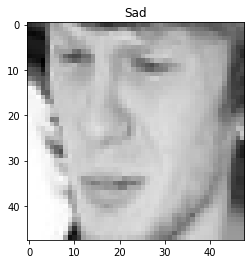

In [24]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']

img, label = train_generator.__next__()

import random

i=random.randint(0, (img.shape[0])-1)
image = img[i]
labl = class_labels[label[i].argmax()]
plt.imshow(image[:,:,0], cmap='gray')
plt.title(labl)
plt.show()

In [25]:
# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(7, activation='softmax'))

model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                  

In [26]:
train_path = "./train/"
test_path = "./test"

In [27]:
num_train_imgs = 0
for root, dirs, files in os.walk(train_path):
    num_train_imgs += len(files)
    
num_test_imgs = 0
for root, dirs, files in os.walk(test_path):
    num_test_imgs += len(files)

In [28]:
epochs=3

history=model.fit(train_generator,
                steps_per_epoch=num_train_imgs//batch_size,
                epochs=epochs,
                validation_data=validation_generator,
                validation_steps=num_test_imgs//batch_size)

model.save('emotion_detection_model_100epochs.h5')

Epoch 1/3
897/897 [==============================] - 133s 148ms/step - loss: 1.7857 - accuracy: 0.2598 - val_loss: 1.6836 - val_accuracy: 0.3075
Epoch 2/3
897/897 [==============================] - 137s 153ms/step - loss: 1.7014 - accuracy: 0.3123 - val_loss: 1.5697 - val_accuracy: 0.3945
Epoch 3/3
897/897 [==============================] - 137s 153ms/step - loss: 1.6102 - accuracy: 0.3688 - val_loss: 1.4863 - val_accuracy: 0.4355


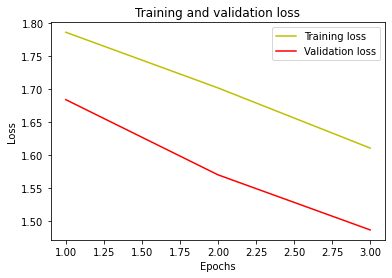

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

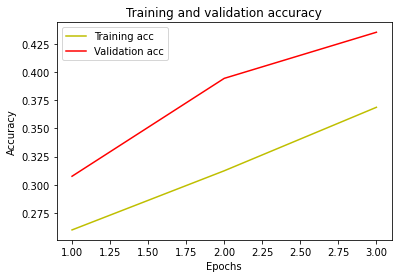

In [30]:
acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
from keras.models import load_model

#Test the model
my_model = load_model('emotion_detection_model_100epochs.h5', compile=False)

#Generate a batch of images
test_img, test_lbl = validation_generator.__next__()
predictions=my_model.predict(test_img)

1/1 [==============================] - 0s 90ms/step


In [32]:
predictions = np.argmax(predictions, axis=1)
test_labels = np.argmax(test_lbl, axis=1)

In [33]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, predictions))

Accuracy =  0.46875


[[2 2 1 0 0 0]
 [0 0 1 0 0 1]
 [0 0 7 0 2 1]
 [1 1 3 1 1 1]
 [0 1 1 0 2 0]
 [0 0 0 0 0 3]]


<AxesSubplot:>

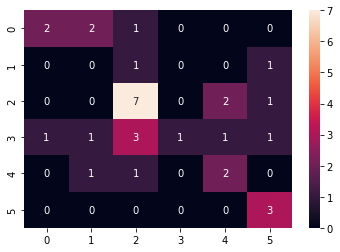

In [34]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, predictions)
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

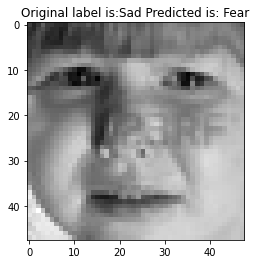

In [35]:
class_labels=['Angry','Disgust', 'Fear', 'Happy','Neutral','Sad','Surprise']
#Check results on a few select images
n=random.randint(0, test_img.shape[0] - 1)
image = test_img[n]
orig_labl = class_labels[test_labels[n]]
pred_labl = class_labels[predictions[n]]
plt.imshow(image[:,:,0], cmap='gray')
plt.title("Original label is:"+orig_labl+" Predicted is: "+ pred_labl)
plt.show()